# Classification in NLP

One of the most common tasks in NLP is to classify text into different categories. The most common example is sentiment classification where given a piece of text we try to classify into different categories of sentiment. 

However, computers dont understand natural language or text! So the first step is to convert the text into a form the computer understands. This involves a series of steps which include: 

1. Preprocessing: It involves converting text into a series of relevant tokens.
2. Feature Extraction: The set of relevant tokens is converted into features.

After this, we follow a typical supervised ML workflow i.e use the feature matrix and corresponding labels to train a classification model via: 

1. Prediction
2. Loss Calculation
3. Gradient Calculation
4. Gradient Descent

And, ad libitum weight updates until we achieve a loss that is acceptably low according to some predetermined criterion. 

## Data Exploration

Before any task, it is important to load and explore the dataset

In [1]:
# Imports and Downloads
import nltk 
from nltk.corpus import twitter_samples
nltk.download('twitter_samples')
import random
import matplotlib.pyplot as plt

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/ruchira/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


In [2]:
# Explore text
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
print('Number of positive tweets: ', len(all_positive_tweets))
all_negative_tweets = twitter_samples.strings('negative_tweets.json')
print('Number of negative tweets: ', len(all_negative_tweets))
print('The type of a tweet entry is: ', type(all_negative_tweets[0]))
print(f'Sample tweet entry: {all_positive_tweets[random.randint(0,5000)]}')

Number of positive tweets:  5000
Number of negative tweets:  5000
The type of a tweet entry is:  <class 'str'>
Sample tweet entry: @NightingaleMCPE Wait, we're not in the YouTube comment section of a video that slightly mentions science, are we? :)


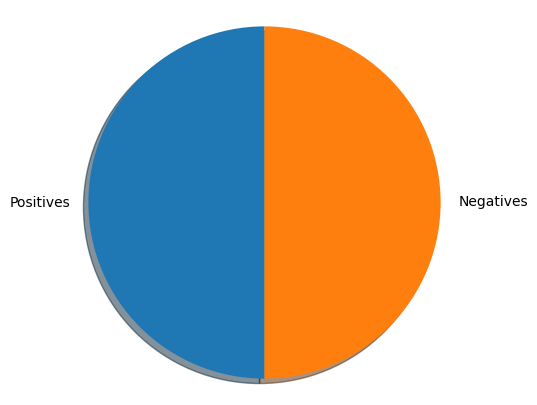

In [3]:
# Visualize data
# use pie chart with labels and sizes from our dataset
fig = plt.figure(figsize=(5, 5))
labels = ['Positives', 'Negatives']
sizes = [len(all_positive_tweets), len(all_negative_tweets)] 
plt.pie(sizes, labels=labels, 
        shadow=True, startangle=90)
plt.axis('equal')  
plt.show()

## Preprocessing

This typically involves: 

1. Tokenization
2. Lowercasing
3. Punctuation Removal
4. Stopword Removal
5. Stemming/Lemmatization

Once each text has been converted into a list of relevant tokens, we extract the corpus vocabulary.

Vocabulary: It is the list of unique tokens present in the entire set of texts. 

In [4]:
# Imports and downloads
from nltk.tokenize import TweetTokenizer 
import string 
from nltk.corpus import stopwords 
stopwords_english = stopwords.words('english') 
from nltk.stem import PorterStemmer  

In [5]:
# Preprocessing Function

def preprocess_tweet(text)-> list: 
    ''' It takes tweet string as input and preprocesses it by tokenization, punctuation removal, stopword removal, and stemming
    The output is a list of tokens'''
    
    # tokenize
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tokenized= tokenizer.tokenize(text)
    # lowercasing
    lowered=[word.lower() for word in tokenized]
    # punctuation and stopword removal
    cleaned=[word for word in lowered if (word not in stopwords_english and word not in string.punctuation) ]
    # stemming
    stemmer = PorterStemmer() 
    stemmed=[stemmer.stem(word) for word in cleaned]

    return stemmed

preprocess_tweet(all_negative_tweets[2])

['heart', 'slide', 'wast', 'basket', ':(']

In [6]:
# Vocabulary Extraction
# prepping corpus
tweets= all_positive_tweets + all_negative_tweets
print(type(tweets))
print(len(tweets))
print(type(tweets[0]))
print(tweets[0])

# preprocess corpus
processed_tweets= [preprocess_tweet(tweet) for tweet in tweets]
print(processed_tweets[0])

# vocabulary
vocabulary=[]
for tweet in processed_tweets:
    for token in tweet:
        if token not in vocabulary:
            vocabulary.append(token)
print(vocabulary[:50])
print(len(vocabulary))

<class 'list'>
10000
<class 'str'>
#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
['#followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']
['#followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)', 'hey', 'jame', 'odd', ':/', 'pleas', 'call', 'contact', 'centr', '02392441234', 'abl', 'assist', 'mani', 'thank', 'listen', 'last', 'night', 'bleed', 'amaz', 'track', 'scotland', 'congrat', 'yeaaah', 'yipppi', 'accnt', 'verifi', 'rqst', 'succeed', 'got', 'blue', 'tick', 'mark', 'fb', 'profil', '15', 'day', 'one', 'irresist', '#flipkartfashionfriday', 'http://t.co/ebz0l2venm', 'like', 'keep', 'love', 'custom']
12407


## Feature Extraction

Since models cannot read text, we need to convert the text into a feature vector.  This can be done in two ways: 

### One Hot Encoding

Each text is converted into a feature vector of length of the vocabulary. Each entry in the vector indicates whether a word in the vocab is present in the text.
   
### Frequency Encoding

Each text is converted into feature vector of length 3 where each value is: 

1. Bias of the model
2. Positive Frequency: For each word in text, sum over the number of times that word occurs in positive tweets
3. Negative Frequency: For each word in text, sum over the number of times that word occurs in negative tweets

The first step is to create a frequency dictionary where each word $w$ has two entries:  $(w,1)$ (number of times the word is in a positive tweet) and $(w,0)$ (number of times the word is in a negative tweet). 

In [7]:
# Imports and downloads
import numpy as np

In [8]:
# Load preprocessed tweets
print(processed_tweets[0])

# Get label list with 1/0 for all tweets
labels = np.append(np.ones((len(all_positive_tweets))), np.zeros((len(all_negative_tweets))))
print(labels[0])

['#followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']
1.0


In [9]:
# Building word frequency dictionary 

def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    yslist = np.squeeze(ys).tolist()

    # looping over all tweets and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in tweet:
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1    
    return freqs

In [10]:
# create frequency dictionary
freqs = build_freqs(processed_tweets, labels)

# check data type
print(f'type(freqs) = {type(freqs)}')

# check length of the dictionary
print(f'len(freqs) = {len(freqs)}')

type(freqs) = <class 'dict'>
len(freqs) = 15063


In [13]:
# extracting features
def extract_features(tweet, freqs, process_tweet=preprocess_tweet):
    '''
    Input: 
        tweet: a string containing one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = preprocess_tweet(tweet)
    
    # 3 elements for [bias, positive, negative] counts
    x = np.zeros(3) 
    
    # bias term is set to 1
    x[0] = 1 
    
    # loop through each word in the list of words
    for word in word_l:
        # look up frequency for (word,1) (positive sentiment)
        x[1] += freqs.get((word, 1), 0)
        
        # look up frequency for (word,0) (negative sentiment)
        x[2] += freqs.get((word, 0), 0)
    
    x = x[None, :]  # adding batch dimension for further processing
    assert(x.shape == (1, 3))
    return x

## Logistic Regression

The next step is to build a logistic regression using the extracted features. A logistic regression takes a regular linear regression and then applies a sigmoid function to bound output as a probability between [0,1]. 

### Prediction


$$ h(z) = \frac{1}{1+\exp^{-z}}$$
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$

Note: The $\theta$ represents the weights of the model and the 'z' output is known as the logits.

### Loss Calculation
The cost function used for logistic regression is the average of the log loss across all training examples:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))\tag{5} $$
* $m$ is the number of training examples
* $y^{(i)}$ is the actual label of training example 'i'.
* $h(z^{(i)})$ is the model's prediction for the training example 'i'.

The loss function for a single training example is
$$ Loss = -1 \times \left( y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) \right)$$

* All the $h$ values are between 0 and 1, so the logs will be negative. That is the reason for the factor of -1 applied to the sum of the two loss terms.
* When the model predicts 1 ($h(z(\theta)) = 1$) and the label 'y' is also 1, the loss for that training example is 0. 
* When the model predicts 0 ($h(z(\theta)) = 0$) and the actual label is also 0, the loss for that training example is 0.

### Gradient Calculation
The gradient of the cost function $J$ with respect to one of the weights $\theta_j$ is:

$$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x^{(i)}_j \tag{5}$$
* 'i' is the index across all 'm' training examples.
* 'j' is the index of the weight $\theta_j$, so $x^{(i)}_j$ is the feature value associated with weight $\theta_j$
*  The product  $(h^{(i)} - y^{(i)}) x^{(i)}_j$ indicates  how much feature $j$ contributed to error for example $i$
*  The gradient value indicates the rate of change of of cost and a positive gradient indicates increasing $\theta_j$ will increase cost $J$ (which we want to lower).

### Gradient Descent

Using the calculated gradient, the weight is adjusted according to a learning parameter (slow or fast descent). To update the weight $\theta_j$, we adjust it by subtracting a fraction of the gradient determined by $\alpha$:

$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$

* The learning rate $\alpha$ is a value that we choose to control how big a single update will be.
* If the gradient is positive, the weight is reduced.
* If the gradient is negative, the weight gets increased.

In [14]:
# Imports and downloads
import numpy as np

In [15]:
# Load and split data
# tweets 
train_pos = all_positive_tweets[:4000]
test_pos = all_positive_tweets[4000:]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

# labels
train_y= np.append(np.ones((len(train_pos),1)), np.zeros((len(train_neg),1)), axis=0) #1D array append along row
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

#verify data shape for train and test
print("The train data is as follows")
print("train_x.shape = " + str(len(train_x)))
print("train_y.shape = " + str(train_y.shape))

print("The test data is as follows")
print("test_x.shape = " + str(len(test_x)))
print("test_y.shape = " + str(test_y.shape))

The train data is as follows
train_x.shape = 8000
train_y.shape = (8000, 1)
The test data is as follows
test_x.shape = 2000
test_y.shape = (2000, 1)


In [16]:
# Preprocess data
processed_train= [preprocess_tweet(tweet) for tweet in train_x]
processed_test= [preprocess_tweet(tweet) for tweet in test_x]

In [17]:
# Prepare frequency dictionary
freqs = build_freqs(processed_train, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 12961


In [18]:
# Prediction function
def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''
    h = 1/(1+np.exp(-z))
    
    return h

In [19]:
# Gradient Descent function
def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m, n+1)
        y: corresponding labels of the input matrix x, dimensions (m, 1)
        theta: weight vector of dimension (n+1, 1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector'''
    m = x.shape[0]                         # number of examples

    for _ in range(num_iters):
        z = x @ theta                      # (m,1)
        h = sigmoid(z)                     # (m,1)

        # cost (log loss)
        J = -(1/m) * (y.T @ np.log(h) + (1 - y).T @ np.log(1 - h))

        # gradient step
        theta = theta - (alpha/m) * (x.T @ (h - y))
        #print(float(J))  

    J = float(J)                         
    return J, theta

In [20]:
# Model Training
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.22516587.
The resulting vector of weights is [np.float64(6e-08), np.float64(0.00053776), np.float64(-0.00055899)]


/var/folders/3x/5gg1gj414mn7flh45l9cm7_80000gn/T/ipykernel_11087/2982187069.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


In [21]:
# Test prediction
def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive
    '''
    
    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)     # shape (1,3)
    
    # make the prediction using x and theta
    z = np.dot(x, theta)                   # shape (1,1)
    y_pred = sigmoid(z)                    # probability in (0,1)
    
    return y_pred

# check the sentiment tweet below
my_tweet = 'I am learning :)'
predict_tweet(my_tweet, freqs, theta)

array([[0.83092719]])

In [22]:
# Model Testing
def test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet=predict_tweet):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    
    
    # the list for storing predictions
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0.0 to the list
            y_hat.append(0.0)

    # convert both to one-dimensional arrays
    y_hat = np.array(y_hat)
    test_y = np.squeeze(test_y)   # ensures shape is (m,)
    
    # compute accuracy
    accuracy = np.mean(y_hat == test_y)

    
    return accuracy

tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.9970


## Naive Bayes